In [1]:
from fastai.data.all import *
from fastai.tabular.all import *

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))
from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *
from enveco.data.las import *
import laspy
from itertools import product
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Polygon

In [3]:
data_path = Path('../../enveco_data/las_2013_autom/')
files = [f for f in os.listdir(data_path) if f.endswith('.las')]

In [4]:
def las_to_geodf(fn:str) -> pd.DataFrame:
    """Open .las-file and return it as dataframe with columns [x, y, z, num_returns, intensity].
    Also convert point cloud to photogrammetric, meaning only one z-coordinate in each x-y -pair"""
    lasfile = laspy.file.File(fn, mode='r')
    lidar_df = pd.DataFrame(columns=['x', 'y', 'z', 'num_returns', 'return_num', 'scan_angle_rank', 'intensity'],
                            data=np.dstack((lasfile.x, 
                                            lasfile.y, 
                                            lasfile.z, 
                                            lasfile.num_returns, 
                                            lasfile.return_num,
                                            lasfile.scan_angle_rank,
                                            lasfile.intensity))[0])
    lidar_df[lidar_df.z < 0] = 0
    lidar_gdf = gpd.GeoDataFrame(lidar_df, geometry=gpd.points_from_xy(lidar_df.x, lidar_df.y))
    lasfile.close()
    return lidar_gdf

In [5]:
def make_grid(xmin, ymax, ncols, nrows, res):
    polys = []
    for col, row in tqdm(list(product(range(ncols), range(nrows)))):
        ytop = ymax - row * res
        ybot = ytop - res
        xleft = xmin + col * res
        xright = xleft + res
        polys.append(Polygon([(xleft,ytop),(xright,ytop),(xright,ybot), (xleft,ybot)]))
    grid = gpd.GeoDataFrame({'geometry':polys})
    return grid

In [9]:
grid = make_grid(np.floor(h1.x.min()), np.ceil(h1.y.max()), 187, 187, 16)

100%|██████████| 34969/34969 [00:00<00:00, 98493.17it/s]


In [6]:
def lastile_to_df(fn, res:int=16, min_h:float=1.3) -> pd.DataFrame:
    "Tile dataframe, to `res` times `res` cells and process as dataframe."
    print('Reading data to GeoDataFrame')
    tile_df = las_to_geodf(fn)
    tile_df.dropna(inplace=True)
    xmin = np.floor(tile_df.x.min())
    xmax = np.ceil(tile_df.x.max())
    ymin = np.floor(tile_df.y.min())
    ymax = np.ceil(tile_df.y.max())
    ncols = int(np.floor((xmax - xmin) / res))
    nrows = int(np.floor((ymax - ymin) / res))
    grid = make_grid(xmin, ymax, ncols, nrows, res)
    tiledata = []
    print('Creating spatial index')
    spatial_index = tile_df.sindex
    print(f'Tiling into {ncols} times {nrows} grid')
    for (col, row), gridcell in tqdm(list(zip(product(range(ncols), range(nrows)), grid.itertuples()))):
        cellpoints_index = list(spatial_index.intersection(gridcell.geometry.bounds))
        cellpoints = tile_df.iloc[cellpoints_index]
        cell = cellpoints[cellpoints.intersects(gridcell.geometry)]
        n = len(cell)
        if n == 0: 
            print(f'Cell R{row}C{col} has no points, skipping')
            continue
        angle = np.nanmean(np.abs(cell.scan_angle_rank))
        if max(cell.z) <= min_h: 
            print(f'Cell R{row}C{col} has maximum height less than {min_h} meters, skipping')
            continue
        cellstats = ([col, row, n, angle] + height_metrics(cell, min_h) + intensity_metrics(cell, min_h) 
                      + class_metrics(cell, min_h) + density_metrics(cell, min_h) + [gridcell.geometry])
        tiledata.append(cellstats)
    tilestats = gpd.GeoDataFrame(columns=['col', 'row'] + point_cloud_metric_cols + ['geometry'], 
                                 data=tiledata, geometry='geometry')
    spatial_index = None
    return tilestats

In [25]:
tile_df = las_to_geodf(data_path/files[0])

In [26]:
tile_df.head()

,x,y,z,num_returns,return_num,scan_angle_rank,intensity,geometry
0,327450.16,6888000.45,0.000,1.0,1.0,-16.0,6.0,POINT (327450.160 6888000.450)
1,327447.38,6888000.41,0.000,1.0,1.0,-16.0,6.0,POINT (327447.380 6888000.410)
2,327446.01,6888000.40,0.000,1.0,1.0,-16.0,8.0,POINT (327446.010 6888000.400)
3,327444.72,6888000.40,0.242,1.0,1.0,-16.0,7.0,POINT (327444.720 6888000.400)
4,327443.28,6888000.37,0.000,1.0,1.0,-16.0,6.0,POINT (327443.280 6888000.370)


<AxesSubplot:>

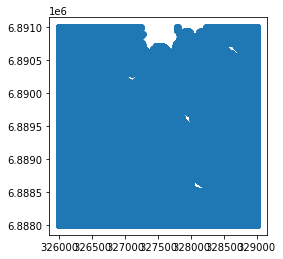

In [28]:
tile_df[tile_df.z > 0].plot()

In [18]:
len(tile_df[tile_df.z < 0]) / len(tile_df)

0.04097898538974573

In [121]:
tile_df = None

In [122]:
tile_df.z.hist(bins=100)

AttributeError: 'NoneType' object has no attribute 'z'

In [120]:
tile_df.shape

NameError: name 'tile_df' is not defined

In [ ]:
tilestats = lastile_to_df(data_path/files[0])
tilestats

Reading data to GeoDataFrame


In [11]:
loaded_ens = load_ensemble('./ensemble_v_noint/')

In [12]:
dls = loaded_ens.dls

In [15]:
test_dl = dls.test_dl(tilestats, bs=128, shuffle=False, drop_last=False,process=True)

In [16]:
res = loaded_ens.get_ensemble_preds(dl=test_dl)

In [14]:
res[1].numpy().shape

(30963, 1)

In [17]:
tilestats['pred_v'] = res[1].numpy()[:,0]

In [105]:
train_gdf

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,geometry
6,901066,326996.14,6888429.45,2013,26.1,16.9,15.8,207.45,0.00,200.43,7.01,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121H1.laz,2013-07-12,C,NaN,NaN,NaN,3,POINT (326996.140 6888429.450)
7,901067,327215.39,6888447.33,2013,35.1,19.9,18.8,324.30,2.29,301.45,20.56,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121H1.laz,2013-07-12,C,NaN,NaN,NaN,6,POINT (327215.390 6888447.330)


In [39]:
tilestats['zq95'].iloc[[10896,12908]]

10896    14.16155
12908    18.85910
Name: zq95, dtype: float64

<AxesSubplot:>

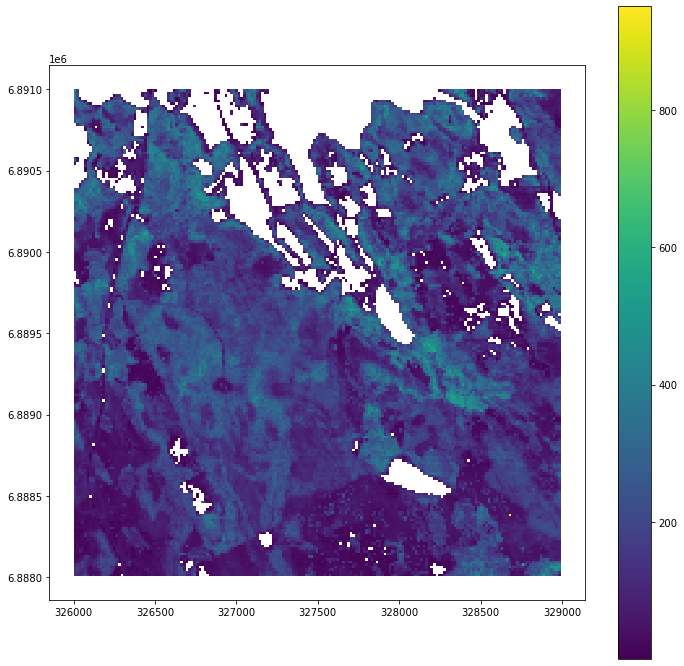

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
tilestats.plot(column='pred_v', ax=ax, legend=True)

In [21]:
h_ens = load_ensemble('ensemble_h_noint/')

In [22]:
dls = h_ens.dls
test_dl = dls.test_dl(tilestats, bs=128, shuffle=False, drop_last=False)

In [23]:
res_h = h_ens.get_ensemble_preds(dl=test_dl)

In [24]:
tilestats['pred_h'] = res_h[1].numpy()[:,0]

<AxesSubplot:>

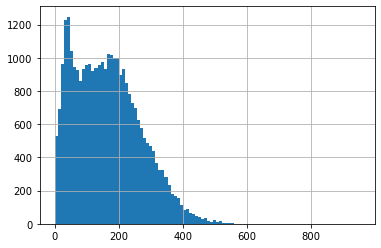

In [19]:
tilestats.pred_v.hist(bins=100)

<AxesSubplot:>

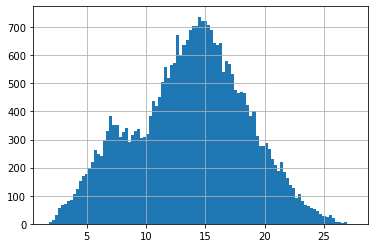

In [25]:
tilestats.pred_h.hist(bins=100)

<AxesSubplot:>

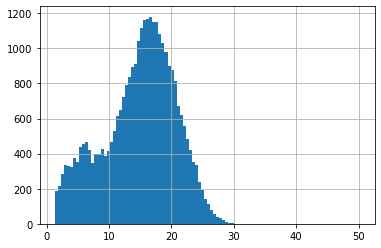

In [40]:
tilestats.zq95.hist(bins=100)

In [27]:
tilestats.pred_h.describe()

count    30711.000000
mean        13.713963
std          4.709371
min          1.771149
25%         10.562328
50%         14.013565
75%         16.979404
max         27.459818
Name: pred_h, dtype: float64

<AxesSubplot:>

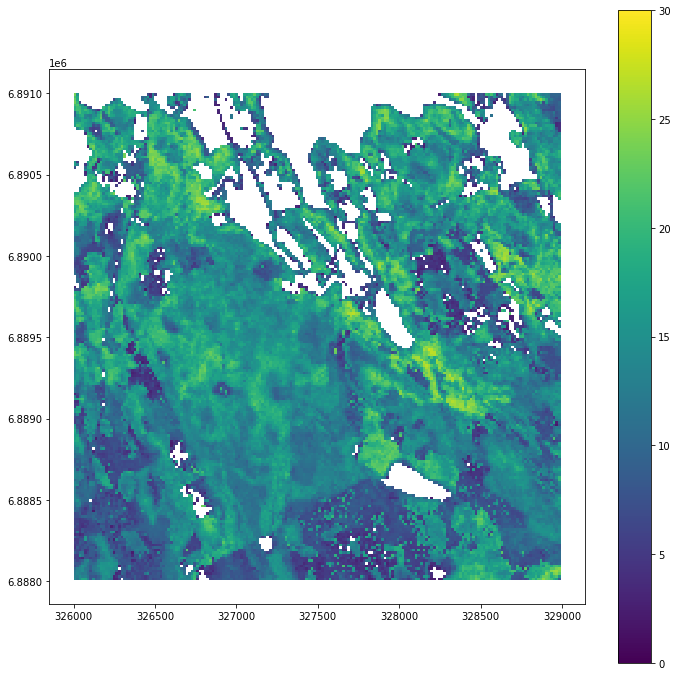

In [31]:
tilestats.plot(column='pred_h', figsize=(12,12), legend=True, vmin=0, vmax=30)

<AxesSubplot:>

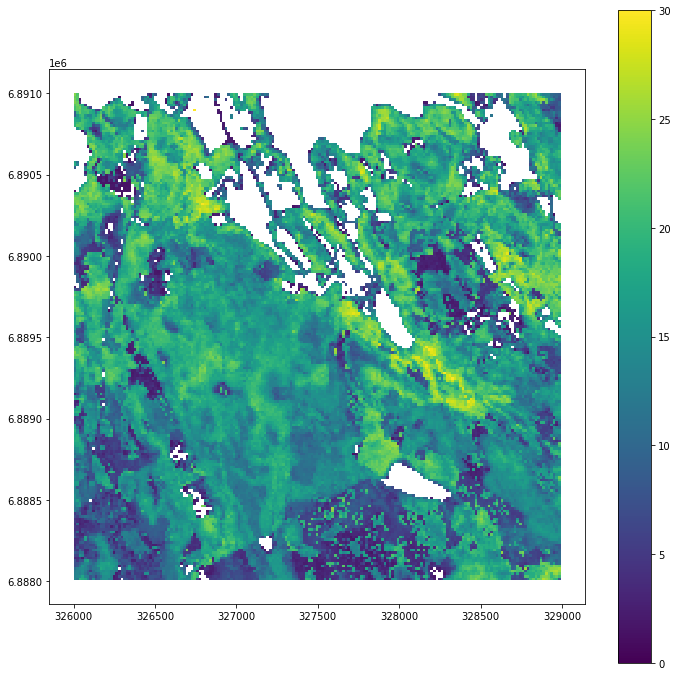

In [41]:
tilestats.plot(column='zq95', figsize=(12,12), legend=True, vmin=0, vmax=30)